In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split

import os
import matplotlib.pyplot as plt
import numpy as np

from model import MLP, MLP_RES, CNN_RES
from dataset import BurgersDataset
from config import (
    DATA_DIR,
    MODEL_PATH,
    INPUT_SIZE,
    HIDDEN_SIZE,
    OUTPUT_SIZE,
    EPOCHS,
    BATCH_SIZE,
    LR,
    SPLIT,
	UNROLL_STEPS
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
from torch.utils.data import Dataset
from config import UNROLL_STEPS
import random

NUM_RES_BLOCKS = 4
KERNEL_SIZE = 5
LR = 1e-6
EPOCHS = 50

UNROLL_STEPS=30
checkpoint_name = "CNN_RES_UNROLL_60.pth"

class BurgersDatasetBPTT(Dataset):
    def __init__(self, file_paths, unroll_steps):
        self.data = []
        self.file_paths = file_paths
        self.unroll_steps = unroll_steps
        self._load_data()

    def _load_data(self):
        for file_path in self.file_paths:
            data = np.load(file_path)
            time_series = data['DataGenerator-Mesh-1D-Internal']
            stride = self.unroll_steps // 2
            for i in range(0, time_series.shape[0] - self.unroll_steps, stride):
                self.data.append((time_series[i], time_series[i+1:i+1+self.unroll_steps]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()
    

# for UNROLL_STEPS in [50, 60]:

# ---------------------------------------------------------------- #

random.seed(42)
all_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith('.npz')]
random.shuffle(all_files)

split_idx = int(SPLIT * len(all_files))
train_files = all_files[:split_idx]
val_files = all_files[split_idx:]

print(f"Found {len(all_files)} simulations.")
print(f"Splitting into {len(train_files)} training and {len(val_files)} validation files.")

train_dataset = BurgersDatasetBPTT(file_paths=train_files, unroll_steps=UNROLL_STEPS)
val_dataset = BurgersDatasetBPTT(file_paths=val_files, unroll_steps=UNROLL_STEPS)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---------------------------------------------------------------- #

def unroll_loss(x, y, unroll_steps=UNROLL_STEPS):
    max_step_loss = 1.0
    loss = torch.tensor(0.0, device=device)
    prev_step = x
    for i in range(unroll_steps):
        y_pred = model(prev_step)
        step_loss = torch.clamp(criterion(y_pred, y[:, i]), max=max_step_loss) # gradient clipping
        loss += step_loss
        prev_step = y_pred
    return loss / unroll_steps

def train_bptt(criterion, optimizer, scheduler, model, train_loader, val_loader, device, UNROLL_STEPS, EPOCHS):
    unroll_steps = UNROLL_STEPS
    max_gradient_norm = 1.0

    best_val_loss = float("inf")
    loss_history = {"train": [], "val": []}
    print("Starting training...")

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            loss = unroll_loss(x, y, unroll_steps)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_gradient_norm)  # gradient clipping
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                # y_pred = model(x)
                # val_loss += criterion(y_pred, y).item()
                loss = unroll_loss(x, y, unroll_steps)
                val_loss += loss.item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            best_model_wts = {k: v.cpu() for k, v in model.state_dict().items()}
            print(f"New best model found at epoch {epoch+1} with val loss {best_val_loss:.6f}")

        
        # Get the current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']
        
        print(
            f"Epoch {epoch+1}/{EPOCHS}, "
            f"Train Loss: {avg_train:.6f}, "
            f"Val Loss: {avg_val:.6f}, "
            f"LR: {current_lr:.8f}"
        )

        loss_history["train"].append(avg_train)
        loss_history["val"].append(avg_val)

        # Step the scheduler at the end of each epoch
        scheduler.step()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    print("Finished training.")

    return loss_history

model = CNN_RES(
    hidden_channels=HIDDEN_SIZE,
    num_blocks=NUM_RES_BLOCKS,
    kernel_size=KERNEL_SIZE
)

# model = MLP_RES(
#     input_size=INPUT_SIZE,
#     hidden_size=HIDDEN_SIZE,
#     output_size=OUTPUT_SIZE
# )


model.load_state_dict(torch.load("models/" + checkpoint_name)) # pre-trained model
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-9)

model_name = "CNN_RES_UNROLL_" + str(UNROLL_STEPS) + ".pth"

if not os.path.exists("models/" + model_name):
    loss_history = train_bptt(criterion, optimizer, scheduler, model, train_loader, val_loader, device, UNROLL_STEPS, EPOCHS)
    torch.save(model.state_dict(), f"models/{model_name}")
    print(f"Model saved")

    plt.figure(figsize=(8, 4), dpi=300)
    plt.plot(loss_history["train"], label="Train Loss")
    plt.plot(loss_history["val"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Unroll steps = {UNROLL_STEPS}")
    plt.yscale("log")
    plt.tight_layout()
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.ylim(1e-4, 1e-1)
    plt.tight_layout()
    plt.savefig(f"models/loss_{model_name}.png")
    plt.show()

    checkpoint_name = model_name

else:
    model.load_state_dict(torch.load(f"models/{model_name}"))
    model.eval()
    print("Model loaded")

#evaluate model on val_loader
val_loss = 0.0
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        loss = unroll_loss(x, y, UNROLL_STEPS)
        val_loss += loss.item()

avg_val_loss = val_loss / len(val_loader)
print(f"Model validation Loss: {avg_val_loss:.6f}")

# clear_memory()

Found 169 simulations.
Splitting into 84 training and 85 validation files.
Model loaded


/tmp/ipykernel_1031872/2931005544.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/" + checkpoint_name)) # pre-trained model
/t

Model validation Loss: 0.019162


torch.Size([32, 128])
torch.Size([32, 60, 128])


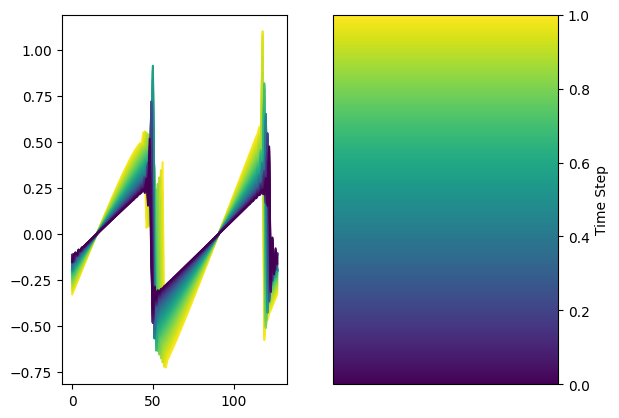

In [3]:
#sample the train_loader
sample = next(iter(train_loader))

x, y = sample
#plot
print(x.shape)
print(y.shape)

fig, axs = plt.subplots(1, 2)
colors = plt.cm.viridis_r(np.linspace(0, 1, UNROLL_STEPS))
for i in range(UNROLL_STEPS):
    axs[0].plot(y[0][i].numpy(), label='Target', color=colors[i])

fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), label='Time Step', cax=axs[1])


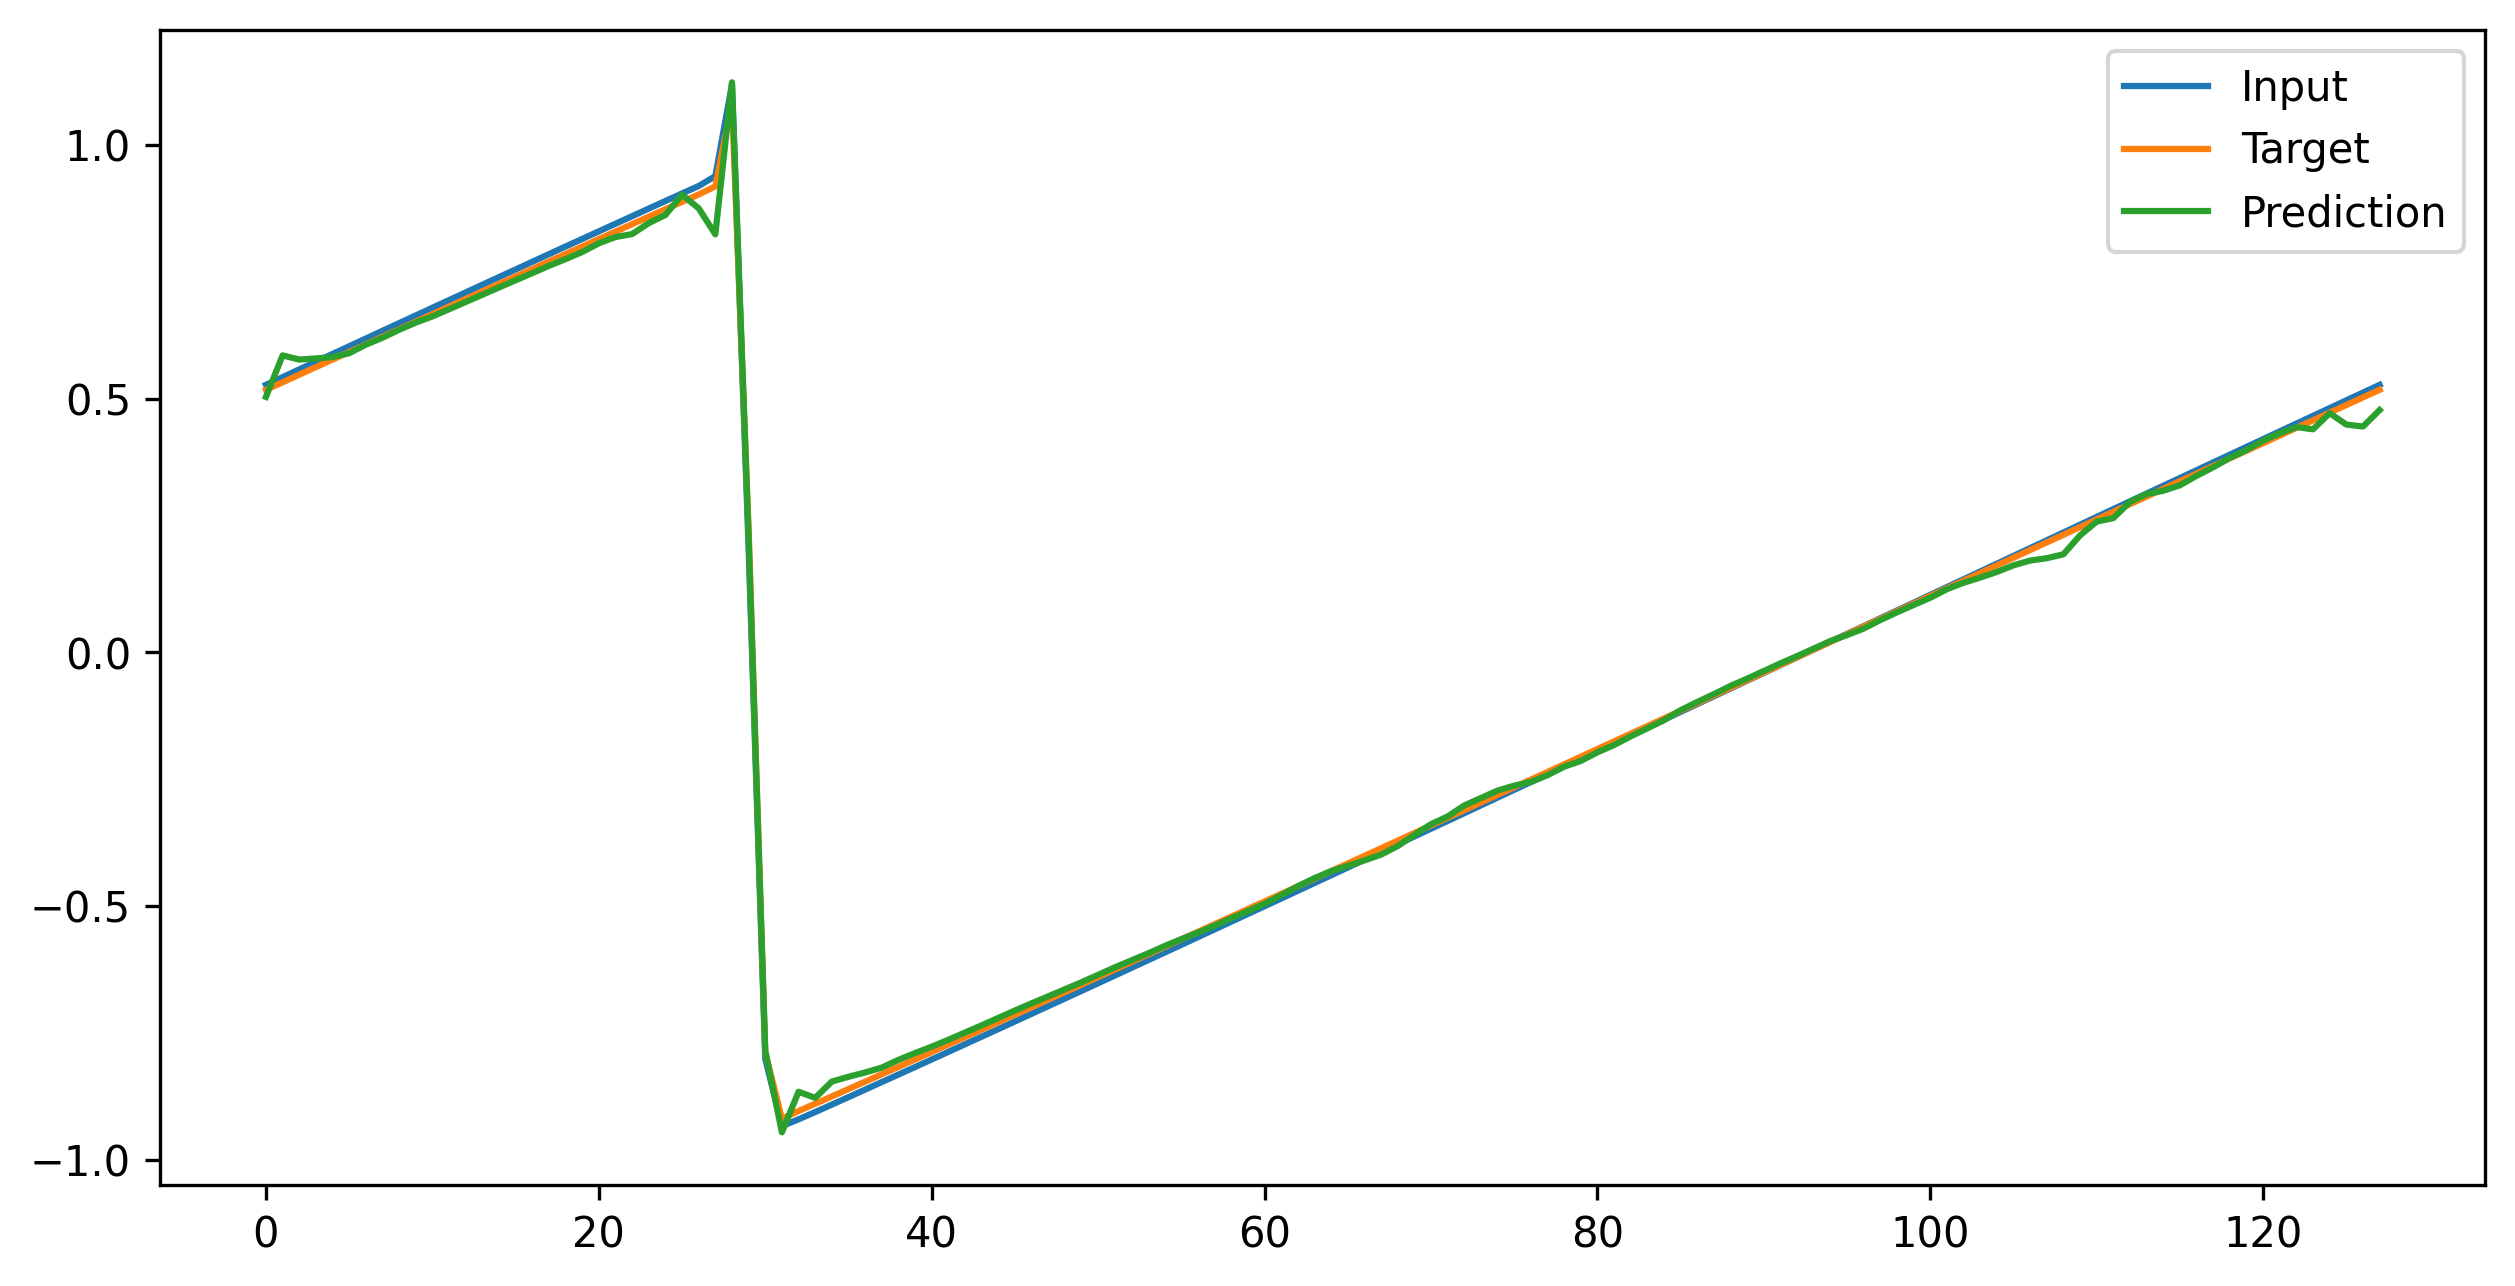

In [24]:
#sample the train_loader
sample = next(iter(train_loader))

x, y = sample

x = x.to(device)
y = y.to(device)

with torch.no_grad():
	y_pred = model(x)
	
y_pred = y_pred.cpu()
x = x.cpu()
y = y.cpu()
#plot 
plt.figure(figsize=(10,5), dpi=300)
plt.plot(x[0].numpy(), label='Input')
plt.plot(y[0][0].numpy(), label='Target')
plt.plot(y_pred[0], label='Prediction')
plt.legend()

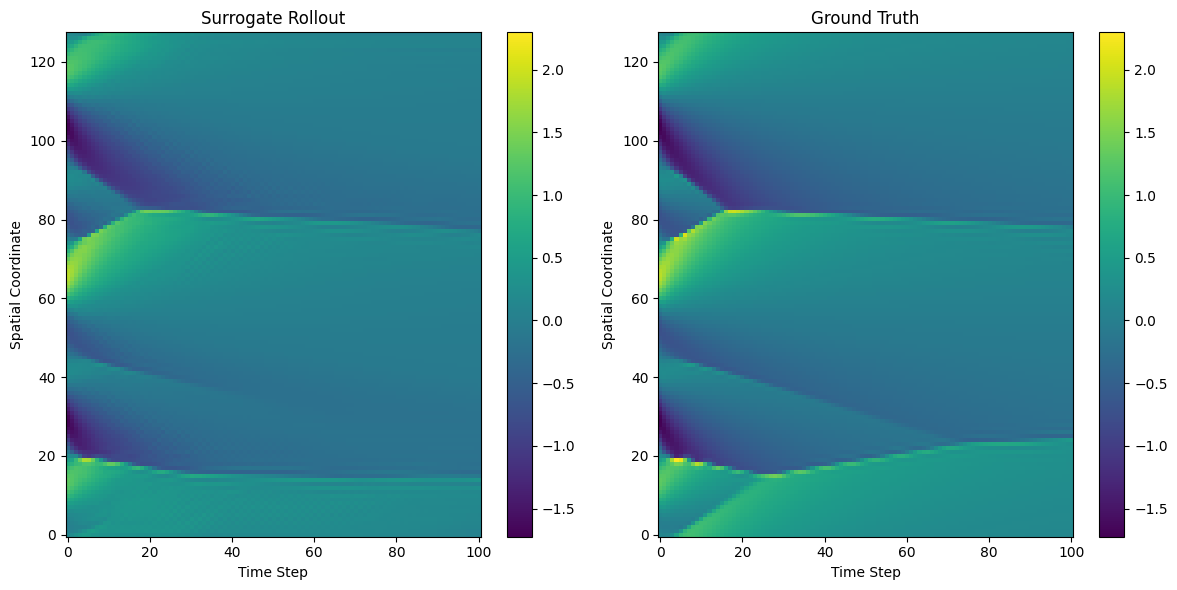

Corrected Rollout MSE over 100 steps: 0.0286


In [43]:
import numpy as np
import os

model.eval()

npz_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.npz')]
if not npz_files:
    print("No .npz files found for evaluation.")
    
file_num = np.random.randint(0, len(npz_files) - 1)
data_path = os.path.join(DATA_DIR, npz_files[file_num])
raw_data = np.load(data_path)['DataGenerator-Mesh-1D-Internal']

rollout_steps = raw_data.shape[0] - 1
rollout_steps //= 1

start_index = 0

x0_np = raw_data[start_index]
ground_truth = raw_data[start_index : start_index + rollout_steps + 1]

predictions = [x0_np]
current_x = torch.from_numpy(x0_np).float().unsqueeze(0)

with torch.no_grad():
    for _ in range(rollout_steps):
        current_x = current_x.to(device)
        y_pred = model(current_x)
        predictions.append(y_pred.squeeze().cpu())
        current_x = y_pred

predictions = np.array(predictions)

vmin = ground_truth.min()
vmax = ground_truth.max()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(predictions.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Surrogate Rollout')
plt.xlabel('Time Step')
plt.ylabel('Spatial Coordinate')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(ground_truth.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.title('Ground Truth')
plt.xlabel('Time Step')
plt.ylabel('Spatial Coordinate')
plt.colorbar()

plt.tight_layout()
plt.savefig('rollout_comparison.png')
plt.show()

mse = np.mean((predictions - ground_truth)**2)
print(f"Corrected Rollout MSE over {rollout_steps} steps: {mse:.4f}")

# CLEAR CUDA MEMORY

In [2]:
def clear_memory():

    import gc

    def _mb(x): return int(x / (1024**2))

    if torch.cuda.is_available():
        torch.cuda.synchronize()
        print(f"CUDA before -> allocated: {_mb(torch.cuda.memory_allocated())} MB, "
            f"reserved: {_mb(torch.cuda.memory_reserved())} MB")

    # Move models to CPU and mark objects for deletion
    to_del = []

    for name in ["model", "optimizer", "scheduler", "x", "y", "y_pred", "current_x", "sample"]:
        if name in globals():
            obj = globals()[name]
            try:
                if isinstance(obj, nn.Module):
                    obj.to("cpu")
            except Exception:
                pass
            to_del.append(name)

    # Also scan globals for any CUDA tensors/modules/optimizers
    for name, obj in list(globals().items()):
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                to_del.append(name)
            elif isinstance(obj, nn.Module) and any(p.is_cuda for p in obj.parameters()):
                try:
                    obj.to("cpu")
                except Exception:
                    pass
                to_del.append(name)
            elif isinstance(obj, torch.optim.Optimizer):
                to_del.append(name)
        except Exception:
            pass

    for name in sorted(set(to_del)):
        try:
            del globals()[name]
        except Exception:
            pass

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        try:
            torch.cuda.ipc_collect()
        except Exception:
            pass
        torch.cuda.synchronize()
        print(f"CUDA after  -> allocated: {_mb(torch.cuda.memory_allocated())} MB, "
            f"reserved: {_mb(torch.cuda.memory_reserved())} MB")

    # Optional: report remaining live CUDA tensors
    live_cuda = 0
    for o in gc.get_objects():
        try:
            if torch.is_tensor(o) and o.is_cuda:
                live_cuda += 1
        except Exception:
            pass
    print(f"Remaining live CUDA tensors: {live_cuda}")

clear_memory()

CUDA before -> allocated: 0 MB, reserved: 0 MB
CUDA after  -> allocated: 0 MB, reserved: 0 MB
Remaining live CUDA tensors: 0


/home/dan/venvs/torch/lib/python3.12/site-packages/torch/__init__.py:1022: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
